# Compare REZ capacity factors

## Load data

BARRA-C2 Capacity factor

In [3]:
# def load_barra_c2_capacity_factor():
#     """
#     Returns DataArray of capacity factors for 2011-2023, 20min resolution
#     """
#     cf_paths = sorted(glob.glob("/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/*.zarr"))
#     cf_paths = cf_paths[32:-1] # select 2011-2013 files
#     datasets = [xr.open_zarr(p, chunks={}) for p in cf_paths]
#     return xr.combine_by_coords(datasets, compat="override", data_vars="minimal", coords="minimal")

In [5]:
cf_barra = fn.load_barra_c2_capacity_factor().cf100m

In [6]:
cf_barra

<xarray.DataArray 'cf100m' (time: 341856, lat: 737, lon: 506)> Size: 510GB
dask.array<concatenate, shape=(341856, 737, 506), dtype=float32, chunksize=(72, 737, 506), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 6kB -43.37 -43.33 -43.29 ... -14.01 -13.97 -13.93
  * lon      (lon) float64 4kB 133.5 133.5 133.6 133.6 ... 153.6 153.7 153.7
  * time     (time) datetime64[ns] 3MB 2011-01-01 ... 2023-12-31T23:40:00

In [19]:
rez_means_barra_20m = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_2011-2023_20min.csv",
    index_col=0
)

CPU times: user 2.69 ms, sys: 362 μs, total: 3.06 ms
Wall time: 3.42 ms


REZ-mean for 1hr data (just select each 20-min timestep on the hour)

In [20]:
rez_means_barra_1hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_2011-2023_1hr.csv",
    index_col=0
)

REZ-mean for 12hr data

In [21]:
rez_means_barra_12hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_2011-2023_12hr.csv",
    index_col=0
)

REZ-mean for 24hr data

In [23]:
rez_means_barra_24hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_2011-2023_24hr.csv",
    index_col=0
)

REZ-mean for 1-week (168 hours) data

In [24]:
168 * 3

504

In [25]:
rez_means_barra_1wk = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_2011-2023_168hr.csv",
    index_col=0
)

Load AEMO and ERA5 stats

In [26]:
# Load AEMO obs and ERA5 REZ stats
cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/capacity_factor/van_der_Wiel/bias_corrected/"

rez_means_era5_aemo = pd.read_csv(
    cf_path + "wind_medium_capacity_factor_van_der_Wiel_era5_REZ_statistics.csv",
    index_col=0
)

Text(0.5, 0, 'REZ')

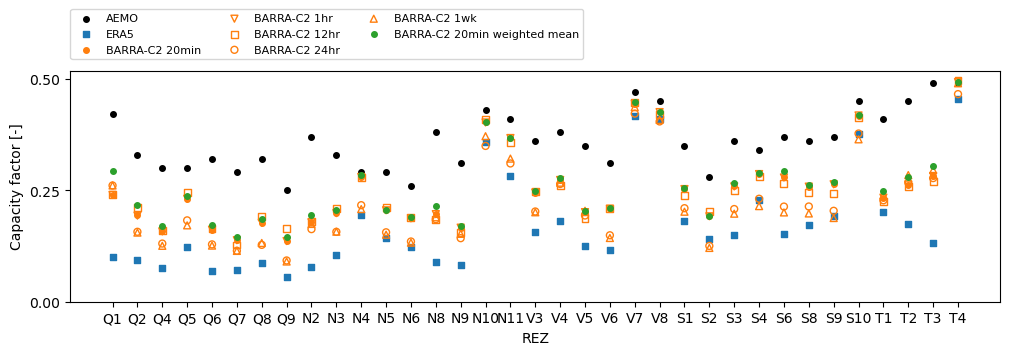

In [24]:
fig, ax = plt.subplots(figsize=(12,3))
s = 16
ylim = 0.5

rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="obs_mean", color="k", s=s, label="AEMO")
rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:blue", s=s, marker="s", label="ERA5")

rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:orange", s=s, marker="o", label="BARRA-C2 20min")
rez_means_barra_1hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="v", label="BARRA-C2 1hr")
rez_means_barra_12hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="s", label="BARRA-C2 12hr")
rez_means_barra_24hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="o", label="BARRA-C2 24hr")
rez_means_barra_1wk.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="^", label="BARRA-C2 1wk")

rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_weighted_mean", color="tab:green", s=s, marker="o", label="BARRA-C2 20min weighted mean")

ax.legend(ncols=3, fontsize=8, loc=(0, 1.05))
ax.set_yticks([0, ylim/2, ylim])
ax.set_ylabel("Capacity factor [-]")
ax.set_xlabel("REZ")

#### Spatial variability

In [25]:
def rez_time_mean(rez):
    """
    Return time-mean of capacity factors for a REZ
    
    rez: str, REZ e.g. 'Q1'
    """
    return cf.where(rez_mask.sel(region=rez), drop=True).mean("time")

In [70]:
q1_mean = rez_time_mean("Q1").compute()

In [96]:
n3_mean = rez_time_mean("N3").compute()

In [71]:
v8_mean = rez_time_mean("V8").compute()

In [97]:
s6_mean = rez_time_mean("S6").compute()

In [98]:
t3_mean = rez_time_mean("T3").compute()

In [132]:
def find_cf_threshold(rez, rez_mean_da):
    """
    Find the smallest capacity factor threshold such that mean of rez_mean_da is equal to AEMO's capacity factor
    
    rez: str, REZ e.g. 'Q1'
    rez_mean_da: DataArray, average capacity factors with dimensions lat, lon
    """
    thresholds = np.arange(0, 1.01, 0.01)
    target = rez_means_era5_aemo.loc[rez]["obs_mean"] - 0.1
    
    i = 0
    t = 0
    all_rez_mean = np.round(rez_mean_da.mean().values, 2)
    # print(all_rez_mean)
    while all_rez_mean < target:
        i += 1
        t = thresholds[i]
        all_rez_mean = np.round(rez_mean_da.where(rez_mean_da >= t).mean().values, 2)
        # print(t, all_rez_mean)
        
    return t, all_rez_mean

In [133]:
q1_thresh, q1_thresh_mean = find_cf_threshold("Q1", q1_mean)
print(q1_thresh, q1_thresh_mean)

0.23 0.33


In [134]:
n3_thresh, n3_thresh_mean = find_cf_threshold("N3", n3_mean)
print(n3_thresh, n3_thresh_mean)

0.2 0.23


In [135]:
v8_thresh, v8_thresh_mean = find_cf_threshold("V8", v8_mean)
print(v8_thresh, v8_thresh_mean)

0 0.43


In [136]:
s6_thresh, s6_thresh_mean = find_cf_threshold("S6", s6_mean)
print(s6_thresh, s6_thresh_mean)

0 0.28


In [137]:
t3_thresh, t3_thresh_mean = find_cf_threshold("T3", t3_mean)
print(t3_thresh, t3_thresh_mean)

0.36 0.4


In [147]:
def plot_rez_thresh(rez, rez_time_mean, rez_thresh, rez_thresh_mean):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    p = rez_time_mean.plot(ax=ax[0])
    ax[0].set_title("REZ mean: "+str(np.round(rez_time_mean.mean().values, 2)) + " (AEMO: " + str(rez_means_era5_aemo.loc[rez]["obs_mean"]) + ")")
    cbar = p.colorbar
    vmin = cbar.norm.vmin
    vmax = cbar.norm.vmax
    
    rez_time_mean.where(rez_time_mean >= rez_thresh).plot(ax=ax[1], vmin=vmin, vmax=vmax)
    ax[1].set_title("REZ mean: "+str(rez_thresh_mean) + " (threshold: " + str(rez_thresh) + ")")

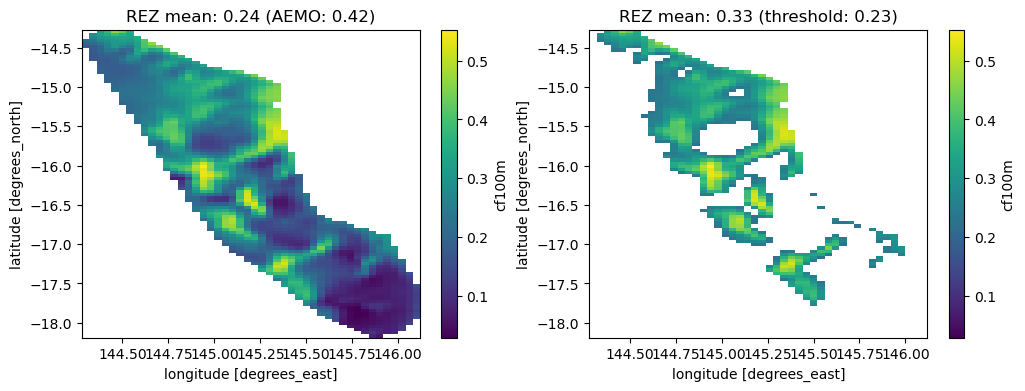

In [148]:
plot_rez_thresh("Q1", q1_mean, q1_thresh, q1_thresh_mean)

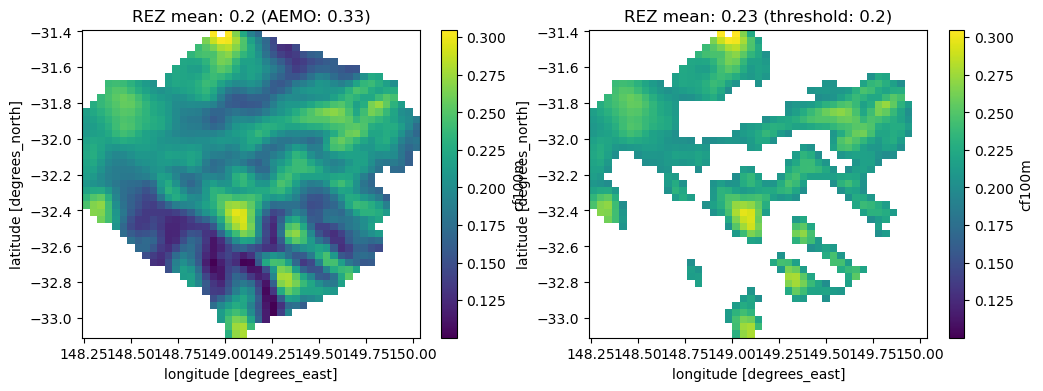

In [149]:
plot_rez_thresh("N3", n3_mean, n3_thresh, n3_thresh_mean)

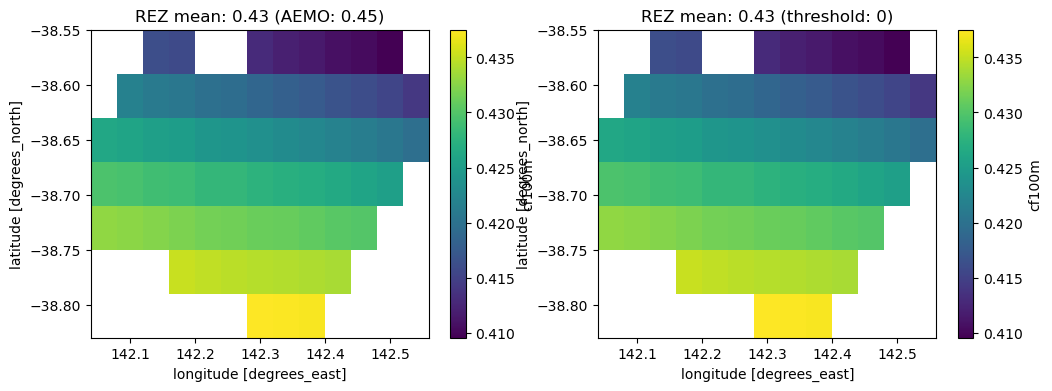

In [150]:
plot_rez_thresh("V8", v8_mean, v8_thresh, v8_thresh_mean)

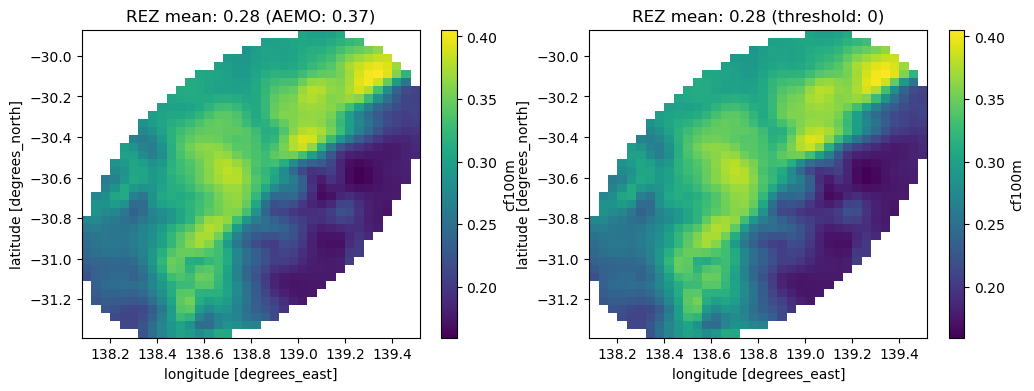

In [151]:
plot_rez_thresh("S6", s6_mean, s6_thresh, s6_thresh_mean)

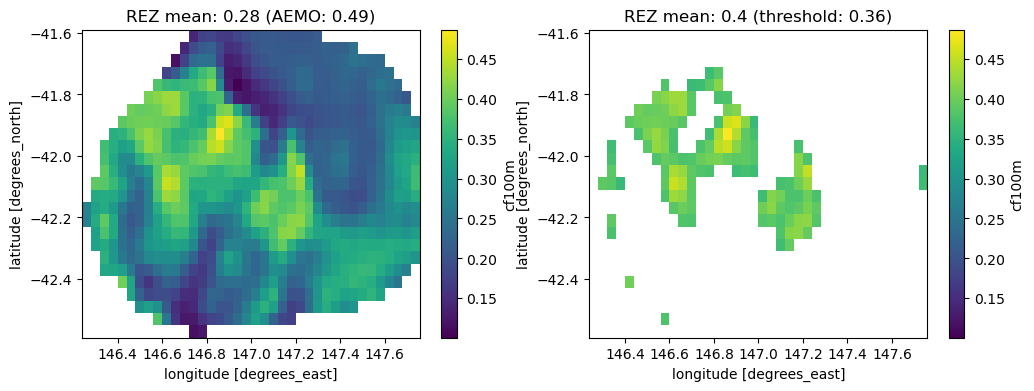

In [152]:
plot_rez_thresh("T3", t3_mean, t3_thresh, t3_thresh_mean)

### Wind droughts - temporal resolution

Compute some rolling mean time series and write to disk

In [14]:
def get_rolling_mean(compute, da, rez, sampling_frequencies, lengths):
    """
    Return rolling mean arrays for desired sampling frequencies and window lengths

    compute: bool, whether to compute or read
    da: array
    rez: str, name of REZ e.g. 'S6'
    sampling_frequencies: list, elements in format '20min' or 'Xhr', where X indicates every X-hourly time step
    lengths: list, elements integers indicating rolling length (in days)
    """
    def _get_skip(t):
        if t == "20min":
            nhrs = 0.33
            skip = None
            hr_time_steps = 24 * 3
        elif t[-2:] == "hr":
            nhrs = int(t[:-2])
            skip = nhrs * 3 # *3 because assumes 20min input data and 0000 first timestep
            hr_time_steps = 24 // nhrs # number of time steps per hour
        else:
            raise ValueError("Incorrect t specified")
        return nhrs, skip, hr_time_steps

    # Get REZ-mean data
    da = da.where(rez_mask.sel(region=rez), drop=True)
    da = da.mean(["lat", "lon"])

    # for each sampling frequency get regional-average array and other variables
    sf_list = []
    roll_list = []
    nhrs_list = []
    for sf in sampling_frequencies:
        _nhr, _skip, _hr_ts = _get_skip(sf)
        
        sf_list.append(da.sel(time=slice(None, None, _skip)))
        roll_list.append(_hr_ts)
        nhrs_list.append(_nhr)

    print(roll_list)
    print(nhrs_list)
    return_list = []
    # For each window length...
    for l in lengths:
        
        len_list = []
        # For each sampling frequency, rolling window and hours-per-timestep
        for (da, roll, nhr) in zip(
            sf_list,
            roll_list,
            nhrs_list
        ):
            filename = "wind_capacity_factor_REZ_"+rez+"_"+str(nhr)+"hr_roll"+str(l)+"day_2011-2023"

            if compute:
                arr = da.chunk({"time": -1}).rolling(time=roll * l).mean()
                # arr = rolling_expand_dim(da, roll)
                arr = arr.to_dataset(name="cf_roll" + str(l) + "day")
                arr.to_netcdf(
                    "/g/data/ng72/dr6273/work/projects/wind_power_comparison/data/" + filename + ".nc"
                )
            else:
                arr = xr.open_mfdataset(
                    "/g/data/ng72/dr6273/work/projects/wind_power_comparison/data/" + filename + ".nc"
                )
                return_list.append(arr)

    if compute == False:
        
        return_dict = {}
        for i, sf in enumerate(sampling_frequencies):
            
            # Get arrays of a particular sampling
            len_arrays = [return_list[x] for x in range(i, len(return_list), len(sampling_frequencies))]
            
            # Get array from dataset and expand dim
            len_arrays = [
                da[list(da.data_vars)[0]].expand_dims(
                    {"window_len": [int(list(da.data_vars)[0][7:-3])]}
                ) for da in len_arrays
            ]
            
            concat_da = xr.concat(len_arrays, dim="window_len")
            return_dict[sf] = concat_da.compute()
            
        return return_dict

In [15]:
sampling_freqs = ["20min", "1hr", "12hr", "24hr"]

In [16]:
window_lengths = [1, 2, 3, 5, 7, 10, 14, 21]

In [17]:
roll_cf_S6 = get_rolling_mean(
    False,
    cf_barra,
    "S6",
    sampling_freqs,
    window_lengths
)

[72, 24, 2, 1]
[0.33, 1, 12, 24]


In [18]:
roll_cf_Q1 = get_rolling_mean(
    False,
    cf_barra,
    "Q1",
    sampling_freqs,
    window_lengths
)

[72, 24, 2, 1]
[0.33, 1, 12, 24]


In [25]:
def drought_freq(da, thresh, dim="time"):
    da = da.dropna("time")
    return da.where(da < thresh).count(dim) / len(da.time)

In [26]:
def drought_intensity(da, freq, dim="time"):
    da = da.dropna("time")
    return da.where(da < da.quantile(freq, "time")).max("time")

In [27]:
intensity_thresh = 0.2 # capacity factor threshold

In [28]:
freq_thresh = 0.2 # quantile of time threshold

In [47]:
def plot_idf(roll_dict, frequency_T):
    fig, ax = plt.subplots(1, 1)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:pink"]
    markers = ["o", "s", "^", "v"]

    if frequency_T == "max":
        frequency_T = [1 / len(_da.time) for _da in roll_dict.values()]
        print(frequency_T)

    for c, m, (key, da) in zip(
        colors,
        markers,
        roll_dict.items()
    ):
        print("Len all time steps:", len(da.time.values))
        
        # da_daily = da.resample(time="1D").mean()
        da_daily = da.isel(time=(da.time.dt.hour == 0) & (da.time.dt.minute == 0))
        print("Len 00:00 time steps:", len(da_daily.time.values), "\n")
        # ax.axhline(da.mean(), ls="--", color=c)
        
        if isinstance(frequency_T, float):
            ax.plot(
                da.window_len,
                drought_intensity(da, frequency_T),
                color=c,
                marker=m,
                label=key
            )
            # ax.plot(
            #     da_daily.window_len,
            #     drought_intensity(da_daily, frequency_T),
            #     ls="--",
            #     color=c,
            #     marker=m,
            #     label=key+" daily"
            # )
        else:
            linestyles = ["-", ":", "--", "-."]
            for ls, fT in zip(linestyles[:], frequency_T[:]):
                ax.plot(
                    da.window_len,
                    drought_intensity(da, fT),
                    color=c,
                    ls=ls,
                    marker=m,
                    label=key+" "+str(fT)
                )
                # ax.plot(
                #     da_daily.window_len,
                #     drought_intensity(da_daily, fT),
                #     ls="-.",
                #     color=c,
                #     marker=m,
                #     label=key+" daily"
                # )
    ax.legend()
    ax.set_xlabel("Duration [d]")
    ax.set_ylabel("Intensity [-]")
    ax.set_title("Sampling frequency vs intensity vs duration")
    ax.set_yticks(np.arange(0, 0.31, 0.1))

Len all time steps: 341856
Len 00:00 time steps: 4748 

Len all time steps: 113952
Len 00:00 time steps: 4748 

Len all time steps: 9496
Len 00:00 time steps: 4748 

Len all time steps: 4748
Len 00:00 time steps: 4748 



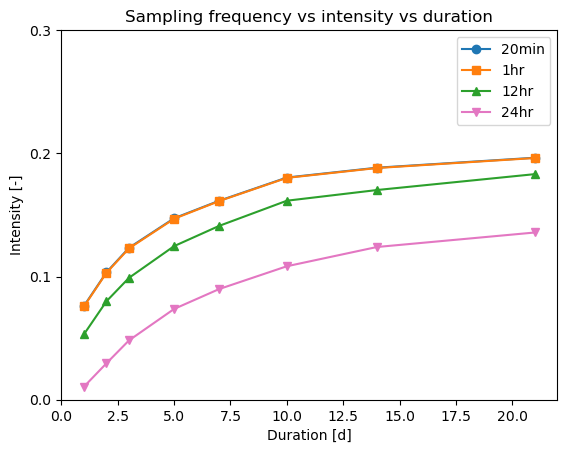

In [48]:
plot_idf(roll_cf_S6, 0.1)

[2.925208274829168e-06, 8.775624824487504e-06, 0.00010530749789385004, 0.00021061499578770007]
4748
4748
4748
4748


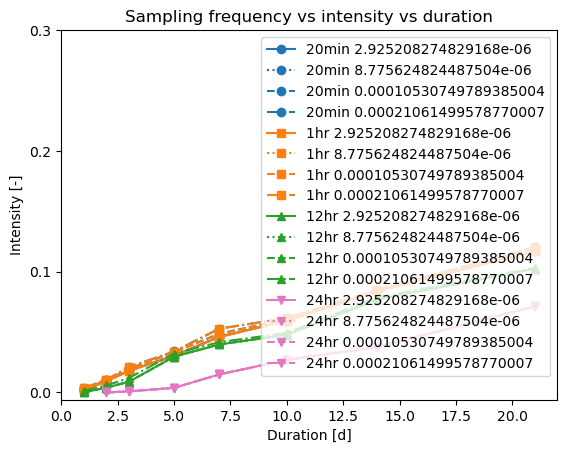

In [105]:
plot_idf(roll_cf_S6, "max")

In [61]:
1/len(roll_cf_S6["24hr"].time)

0.00021061499578770007

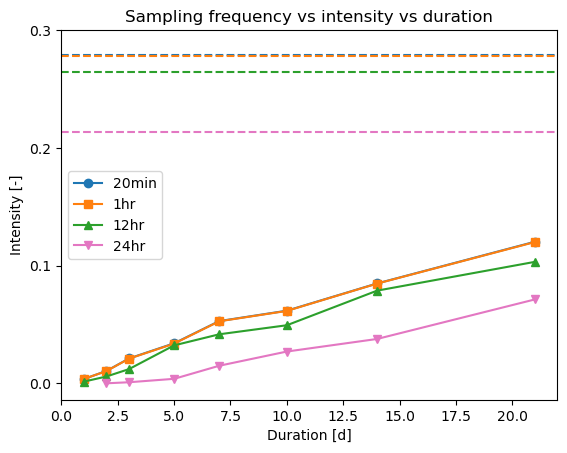

In [62]:
plot_idf(roll_cf_S6, 1/len(roll_cf_S6["24hr"].time))

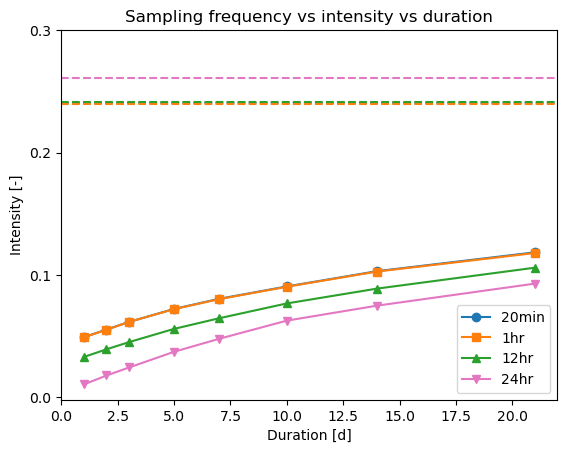

In [53]:
plot_idf(roll_cf_Q1, 0.1)